In [1]:
# Energy Demand Clustering and Forecasting Analysis
# For use in Jupyter/Colab notebook

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configuration
DATA_FILE = 'dataset_cleaned.csv'  # Update this path if needed
CLUSTER_FEATURES = ['precipIntensity', 'precipProbability', 'temperature', 'apparentTemperature']
FORECAST_HORIZON = 24  # 24 hours ahead forecast

print(f"Starting energy demand analysis on {DATA_FILE}...")

Starting energy demand analysis on dataset_cleaned.csv...


In [3]:
# Load data
try:
    df = pd.read_csv(DATA_FILE)
    print(f"Successfully loaded {DATA_FILE}. Shape: {df.shape}")
    print("Columns:", df.columns.tolist())
    
    # Check for required columns
    required_columns = ['demand', 'hour', 'day', 'temperature']
    for col in required_columns:
        if col not in df.columns:
            if col == 'temperature' and 'apparentTemperature' in df.columns:
                print("Using 'apparentTemperature' instead of 'temperature'")
                df['temperature'] = df['apparentTemperature']
            else:
                print(f"Warning: Required column '{col}' not found in dataset")
                
except FileNotFoundError:
    print(f"Error: {DATA_FILE} not found.")
    # Use this for demo if file not found
    print("Generating synthetic data for demonstration...")
    # Create synthetic dataset with 1000 records
    np.random.seed(42)
    n_samples = 1000
    
    # Generate time series index
    timestamps = pd.date_range(start='2018-01-01', periods=n_samples, freq='H')
    
    # Create synthetic weather and demand data
    synthetic_data = {
        'time': timestamps,
        'demand': np.random.normal(loc=50, scale=15, size=n_samples) + 
                 15 * np.sin(np.linspace(0, 4*np.pi, n_samples)),  # cyclical pattern
        'temperature': np.random.normal(loc=20, scale=8, size=n_samples) + 
                      10 * np.sin(np.linspace(0, 2*np.pi, n_samples)),  # seasonal pattern
        'precipIntensity': np.random.exponential(scale=0.1, size=n_samples),
        'precipProbability': np.random.beta(a=0.5, b=2, size=n_samples),
        'humidity': np.random.uniform(low=0.3, high=1.0, size=n_samples),
        'windSpeed': np.random.gamma(shape=2, scale=2, size=n_samples)
    }
    
    df = pd.DataFrame(synthetic_data)
    df['apparentTemperature'] = df['temperature'] + np.random.normal(loc=0, scale=1, size=n_samples)
    print(f"Created synthetic dataset. Shape: {df.shape}")

Successfully loaded dataset_cleaned.csv. Shape: (9987, 31)
Columns: ['icon', 'precipIntensity', 'cloudCover', 'ozone', 'visibility', 'humidity', 'windBearing', 'pressure', 'temperature', 'time', 'windSpeed', 'uvIndex', 'precipProbability', 'summary', 'dewPoint', 'city', 'local_time', 'demand', 'region', 'hour', 'day', 'month', 'day_of_week', 'is_weekend', 'season', 'heat_index', 'temp_diff_from_daily_avg', 'is_rainy', 'is_cloudy', 'time_of_day', 'temp_humidity_interaction']


In [4]:
# Data preprocessing
print("\n--- Data Preprocessing ---")

# Check if we have temporal sequence via 'time' column
if 'time' in df.columns:
    # Convert to datetime if needed
    if isinstance(df['time'].iloc[0], str) or df['time'].dtype == 'object':
        df['time'] = pd.to_datetime(df['time'])
    else:
        df['time'] = pd.to_datetime(df['time'], unit='s')
    
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    print("Data sorted by timestamp")
elif 'local_time' in df.columns:
    # Try local_time instead
    df['local_time'] = pd.to_datetime(df['local_time'])
    df.set_index('local_time', inplace=True)
    df.sort_index(inplace=True)
    print("Data sorted by local timestamp")
else:
    print("Warning: No timestamp column found. Data may not be in chronological order.")

# Handle missing values
print("\nHandling missing values...")
missing_before = df.isnull().sum().sum()
print(f"Total missing values before imputation: {missing_before}")

if missing_before > 0:
    # For numeric columns, fill with mean
    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mean(), inplace=True)
    
    # For categorical columns, fill with mode
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    missing_after = df.isnull().sum().sum()
    print(f"Total missing values after imputation: {missing_after}")


--- Data Preprocessing ---
Data sorted by timestamp

Handling missing values...
Total missing values before imputation: 0


In [5]:
# Feature Engineering
print("\n--- Feature Engineering ---")

# Create lag features
def create_lag_features(df, target_col, lag_hours=[1, 24, 168]):
    """Create lag features for time series"""
    lag_df = df.copy()
    for lag in lag_hours:
        lag_df[f'{target_col}_lag{lag}'] = lag_df[target_col].shift(lag)
    return lag_df

# Create rolling window features
def create_rolling_features(df, target_col, windows=[6, 12, 24], statistics=['mean', 'std']):
    """Create rolling window features for time series"""
    roll_df = df.copy()
    for window in windows:
        for stat in statistics:
            if stat == 'mean':
                roll_df[f'{target_col}_roll{window}_{stat}'] = roll_df[target_col].rolling(window=window, min_periods=1).mean()
            elif stat == 'std':
                roll_df[f'{target_col}_roll{window}_{stat}'] = roll_df[target_col].rolling(window=window, min_periods=1).std().fillna(0)
    return roll_df

# Create cyclical features for hour, day of week, month
def create_cyclical_features(df, col_name, period):
    """Create sin and cos features to represent cyclical data"""
    df[f'{col_name}_sin'] = np.sin(2 * np.pi * df[col_name]/period)
    df[f'{col_name}_cos'] = np.cos(2 * np.pi * df[col_name]/period)
    return df


--- Feature Engineering ---


In [6]:
# Check if hour, day, month are already in the dataset
time_features = []
if isinstance(df.index, pd.DatetimeIndex):
    if 'hour' not in df.columns:
        df['hour'] = df.index.hour
        time_features.append('hour')
        print("Created 'hour' feature")
        
    if 'day' not in df.columns:
        df['day'] = df.index.day
        time_features.append('day')
        print("Created 'day' feature")
        
    if 'month' not in df.columns:
        df['month'] = df.index.month
        time_features.append('month')
        print("Created 'month' feature")
        
    if 'day_of_week' not in df.columns:
        df['day_of_week'] = df.index.dayofweek
        time_features.append('day_of_week')
        print("Created 'day_of_week' feature")

print("\nCreating lag features...")
try:
    if hasattr(df.index, 'is_monotonic_increasing') and not df.index.is_monotonic_increasing:
        print("Warning: Time index is not strictly increasing. Sorting index...")
        df = df.sort_index()
    
    # Create lags for demand (1 hour, 24 hours, 168 hours (1 week))
    df = create_lag_features(df, 'demand', lag_hours=[1, 24, 168])
    print("Created lag features: demand_lag1, demand_lag24, demand_lag168")
except Exception as e:
    print(f"Error creating lag features: {e}")

print("\nCreating rolling window features...")
try:
    df = create_rolling_features(df, 'demand', windows=[6, 12, 24], statistics=['mean', 'std'])
    print("Created rolling window features")
except Exception as e:
    print(f"Error creating rolling window features: {e}")

print("\nCreating cyclical features...")
if 'hour' in df.columns:
    df = create_cyclical_features(df, 'hour', 24)
    print("Created cyclical features for hour")
    
if 'day_of_week' in df.columns:
    df = create_cyclical_features(df, 'day_of_week', 7)
    print("Created cyclical features for day of week")
    
if 'month' in df.columns:
    df = create_cyclical_features(df, 'month', 12)
    print("Created cyclical features for month")

# Handle any new missing values from feature engineering
df.dropna(inplace=True)
print(f"\nFinal dataframe shape after preprocessing: {df.shape}")


Creating lag features...
Created lag features: demand_lag1, demand_lag24, demand_lag168

Creating rolling window features...
Created rolling window features

Creating cyclical features...
Created cyclical features for hour
Created cyclical features for day of week
Created cyclical features for month

Final dataframe shape after preprocessing: (9819, 45)



Sample of preprocessed data:
                            icon  precipIntensity  cloudCover       ozone  \
time                                                                        
2018-07-14 09:00:00  clear-night           0.0000        0.06  304.298784   
2018-07-14 10:00:00  clear-night           0.0000        0.00  304.298784   
2018-07-14 11:00:00  clear-night           0.0000        0.02  304.298784   
2018-07-14 11:00:00    clear-day           0.0000        0.12  304.298784   
2018-07-14 15:00:00    clear-day           0.0006        0.05  304.298784   

                     visibility  humidity  windBearing  pressure  temperature  \
time                                                                            
2018-07-14 09:00:00       9.997      0.79        232.0    1021.6        65.60   
2018-07-14 10:00:00       9.997      0.72        180.0    1016.0        80.24   
2018-07-14 11:00:00       9.997      0.78        171.0    1016.2        78.80   
2018-07-14 11:00:00      

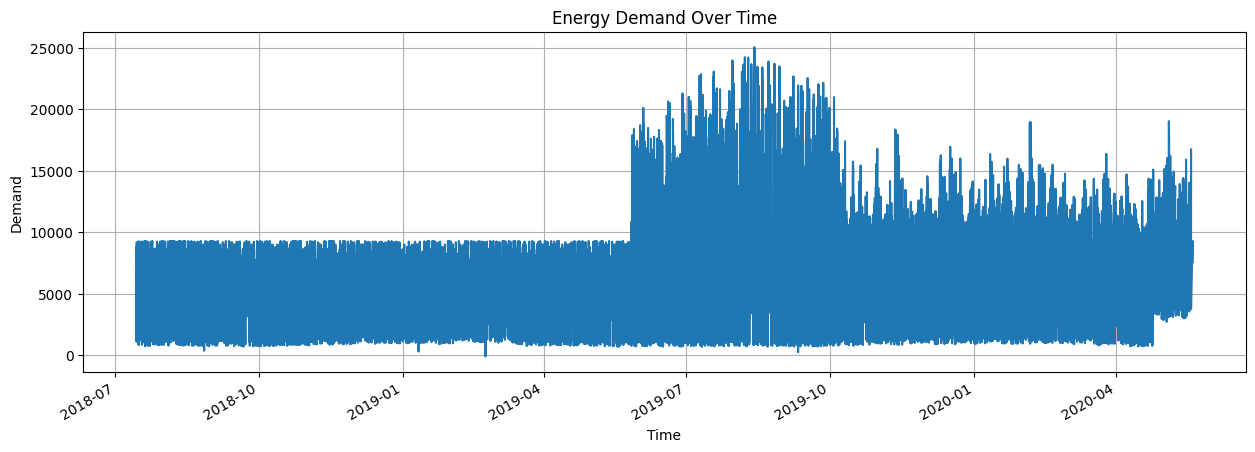

In [7]:
# Display the first few rows of the preprocessed data
print("\nSample of preprocessed data:")
print(df.head())

# Summary statistics
print("\nSummary statistics for key features:")
print(df[['demand', 'temperature', 'hour']].describe())

# Plot the demand over time
plt.figure(figsize=(15, 5))
if 'demand' in df.columns:
    df['demand'].plot()
    plt.title('Energy Demand Over Time')
    plt.xlabel('Time')
    plt.ylabel('Demand')
    plt.grid(True)
    plt.show()

In [8]:
# Part 1: Clustering Analysis
print("\n=== PART 1: CLUSTERING ANALYSIS ===")

# Select features for clustering
cluster_features = [f for f in CLUSTER_FEATURES if f in df.columns]
print(f"Using features for clustering: {cluster_features}")

# Scale the features
df_cluster = df[cluster_features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)
print("Features scaled for clustering")

# PCA for visualization and dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")


=== PART 1: CLUSTERING ANALYSIS ===
Using features for clustering: ['precipIntensity', 'precipProbability', 'temperature']
Features scaled for clustering
PCA explained variance ratio: [0.51905462 0.33302504]



Determining optimal number of clusters...
For n_clusters = 2, the silhouette score is 0.6828
For n_clusters = 3, the silhouette score is 0.4911
For n_clusters = 4, the silhouette score is 0.5024
For n_clusters = 5, the silhouette score is 0.5049
For n_clusters = 6, the silhouette score is 0.4331
For n_clusters = 7, the silhouette score is 0.4540
For n_clusters = 8, the silhouette score is 0.4571
For n_clusters = 9, the silhouette score is 0.4186
For n_clusters = 10, the silhouette score is 0.4347


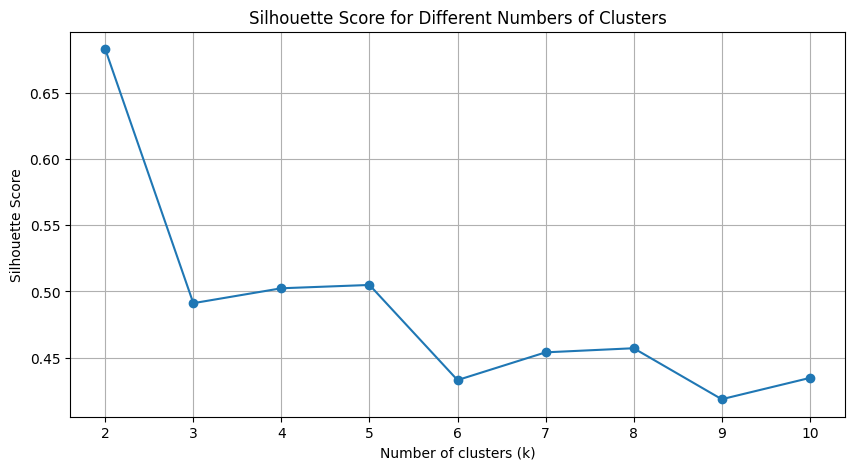


Best number of clusters based on silhouette score: 2
Best silhouette score: 0.6828


In [9]:
# Determine optimal number of clusters using silhouette score
print("\nDetermining optimal number of clusters...")
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Find the optimal k based on silhouette score
best_k = k_range[np.argmax(silhouette_scores)]
print(f"\nBest number of clusters based on silhouette score: {best_k}")
print(f"Best silhouette score: {max(silhouette_scores):.4f}")


Applying K-Means clustering with k=2...
K-Means clustering completed.
Cluster counts:
cluster
0    9183
1     636
Name: count, dtype: int64


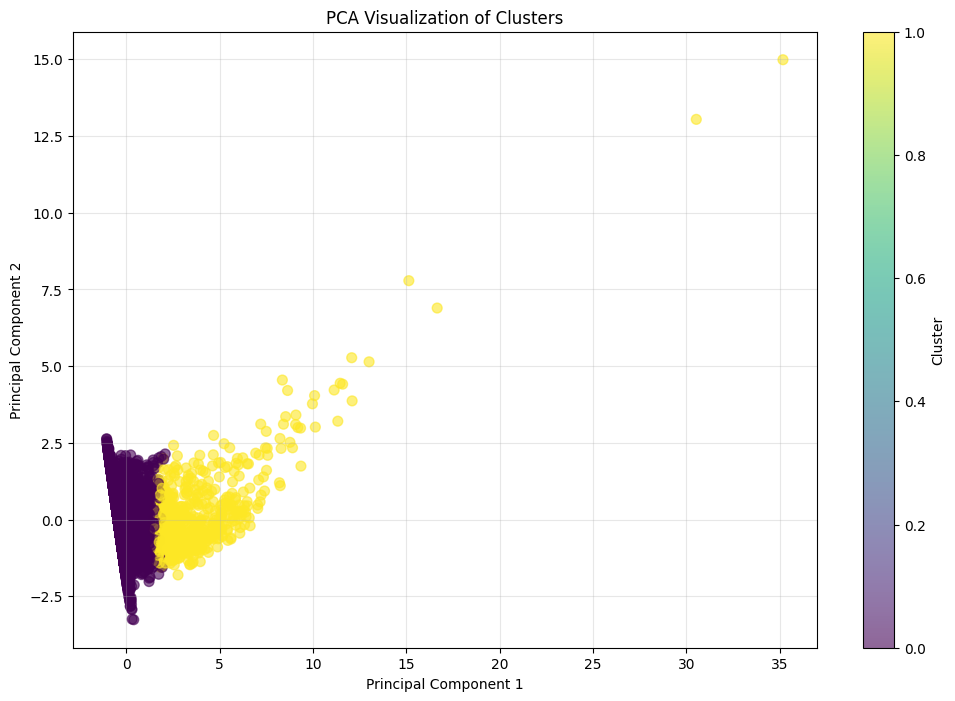

In [10]:
# Apply K-Means with optimal k
print(f"\nApplying K-Means clustering with k={best_k}...")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)
print("K-Means clustering completed.")
print("Cluster counts:")
cluster_counts = df['cluster'].value_counts()
print(cluster_counts)

# Create a plot with PCA components colored by cluster
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.6, s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(alpha=0.3)
plt.show()


Cluster Centers (Original Scale):
         precipIntensity  precipProbability  temperature
Cluster                                                 
0               0.001694           0.031689    63.605075
1               0.051594           0.587017    54.374647


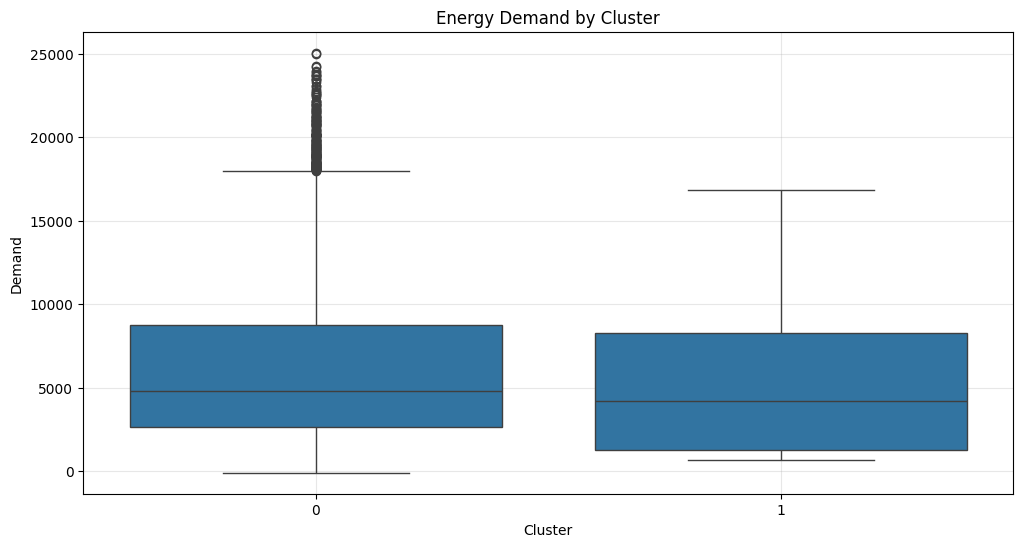

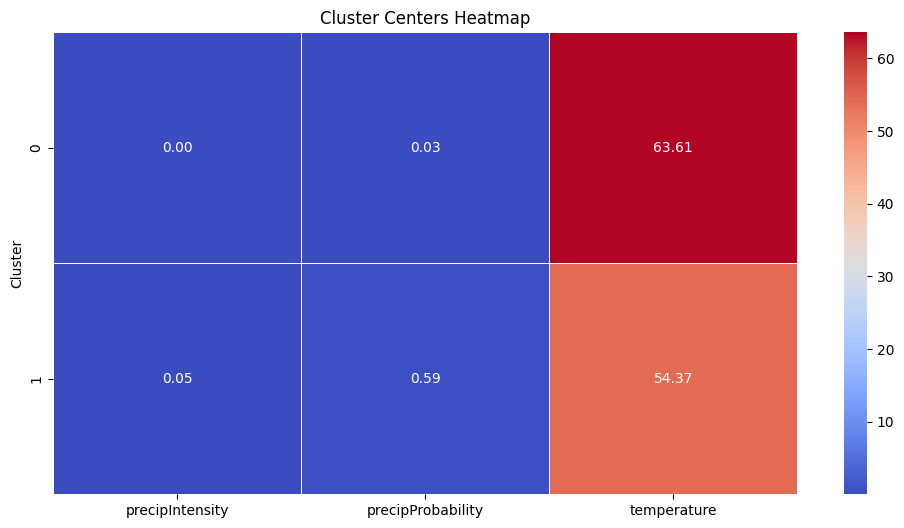

In [11]:
# Analyze cluster centers
centers = kmeans.cluster_centers_
centers_df = pd.DataFrame(scaler.inverse_transform(centers), columns=cluster_features)
centers_df.index.name = 'Cluster'
print("\nCluster Centers (Original Scale):")
print(centers_df)

# Analyze relationship between clusters and demand
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='demand', data=df)
plt.title('Energy Demand by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Demand')
plt.grid(alpha=0.3)
plt.show()

# Plot cluster centers as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(centers_df, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f')
plt.title('Cluster Centers Heatmap')
plt.show()

In [12]:
# Cluster descriptions
print("\nCluster Descriptions:")
for i in range(best_k):
    cluster_data = df[df['cluster'] == i]
    print(f"Cluster {i} ({len(cluster_data)} points, {len(cluster_data)/len(df):.1%} of data):")
    
    # Describe key features
    for feature in cluster_features:
        print(f"  {feature}: {centers_df.iloc[i][feature]:.2f} (Dataset Mean: {df[feature].mean():.2f})")
    
    # Time patterns if available
    if 'hour' in df.columns:
        hour_dist = cluster_data['hour'].value_counts(normalize=True).nlargest(3)
        print(f"  Common hours: {', '.join([f'{h}:00 ({p:.1%})' for h, p in hour_dist.items()])}")
    
    if 'day_of_week' in df.columns:
        dow_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
        dow_dist = cluster_data['day_of_week'].value_counts(normalize=True).nlargest(3)
        print(f"  Common days: {', '.join([f'{dow_mapping[d]} ({p:.1%})' for d, p in dow_dist.items()])}")
    
    # Demand statistics
    if 'demand' in df.columns:
        print(f"  Average demand: {cluster_data['demand'].mean():.2f} (Dataset Mean: {df['demand'].mean():.2f})")
        print(f"  Demand range: {cluster_data['demand'].min():.2f} - {cluster_data['demand'].max():.2f}")
    
    print()


Cluster Descriptions:
Cluster 0 (9183 points, 93.5% of data):
  precipIntensity: 0.00 (Dataset Mean: 0.00)
  precipProbability: 0.03 (Dataset Mean: 0.07)
  temperature: 63.61 (Dataset Mean: 63.01)
  Common hours: 14:00 (4.6%), 7:00 (4.6%), 8:00 (4.5%)
  Common days: Monday (14.7%), Friday (14.5%), Wednesday (14.5%)
  Average demand: 6135.85 (Dataset Mean: 6076.74)
  Demand range: -98.00 - 25064.00

Cluster 1 (636 points, 6.5% of data):
  precipIntensity: 0.05 (Dataset Mean: 0.00)
  precipProbability: 0.59 (Dataset Mean: 0.07)
  temperature: 54.37 (Dataset Mean: 63.01)
  Common hours: 9:00 (5.5%), 5:00 (5.3%), 19:00 (5.0%)
  Common days: Saturday (17.6%), Friday (17.3%), Thursday (15.3%)
  Average demand: 5223.14 (Dataset Mean: 6076.74)
  Demand range: 688.00 - 16831.00



In [13]:
# Part 2: Time Series Forecasting
print("\n=== PART 2: TIME SERIES FORECASTING ===")

# Select features for modeling
features = [
    'precipIntensity', 'precipProbability', 'temperature', 
    'hour', 'day_of_week', 'month',
    'demand_lag1', 'demand_lag24', 'demand_lag168',
    'demand_roll24_mean', 'hour_sin', 'hour_cos'
]

# Make sure all features exist in the dataframe
features = [f for f in features if f in df.columns]
print(f"Selected features: {features}")

target = 'demand'

# Split data into train/test sets
# Use approximately 80% for training, 20% for testing
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# Create X, y datasets
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data splitting and scaling complete")


=== PART 2: TIME SERIES FORECASTING ===
Selected features: ['precipIntensity', 'precipProbability', 'temperature', 'hour', 'day_of_week', 'month', 'demand_lag1', 'demand_lag24', 'demand_lag168', 'demand_roll24_mean', 'hour_sin', 'hour_cos']
Training data shape: (7855, 46)
Testing data shape: (1964, 46)
Data splitting and scaling complete


In [14]:
# Create naive forecast (baseline)
print("\n--- Creating Naive Forecast (Baseline) ---")

# Use the value from 24 hours ago as naive forecast
naive_predictions = test_df['demand_lag24']

# Evaluate naive forecast
naive_mae = mean_absolute_error(y_test, naive_predictions)
naive_rmse = np.sqrt(mean_squared_error(y_test, naive_predictions))
naive_mape = np.mean(np.abs((y_test - naive_predictions) / y_test)) * 100

print(f"Naive Forecast (Previous Day's Same Hour) Performance:")
print(f"MAE: {naive_mae:.2f}")
print(f"RMSE: {naive_rmse:.2f}")
print(f"MAPE: {naive_mape:.2f}%")


--- Creating Naive Forecast (Baseline) ---
Naive Forecast (Previous Day's Same Hour) Performance:
MAE: 4706.52
RMSE: 6039.54
MAPE: 140.75%


In [15]:
# Model training & evaluation function
def train_evaluate_model(model, name, X_train, y_train, X_test, y_test, baseline_metrics):
    print(f"\n--- Training {name} Model ---")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)
    
    # Calculate improvement over baseline
    mae_improvement = ((baseline_metrics['mae'] - mae) / baseline_metrics['mae']) * 100
    rmse_improvement = ((baseline_metrics['rmse'] - rmse) / baseline_metrics['rmse']) * 100
    mape_improvement = ((baseline_metrics['mape'] - mape) / baseline_metrics['mape']) * 100
    
    print(f"{name} Model Performance:")
    print(f"MAE: {mae:.2f} ({mae_improvement:.1f}% improvement over baseline)")
    print(f"RMSE: {rmse:.2f} ({rmse_improvement:.1f}% improvement over baseline)")
    print(f"MAPE: {mape:.2f}% ({mape_improvement:.1f}% improvement over baseline)")
    print(f"R²: {r2:.4f}")
    
    # Visualize actual vs predicted for a sample of the test data
    sample_size = min(100, len(y_test))
    sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.iloc[sample_indices].values, 'b-', label='Actual')
    plt.plot(y_pred[sample_indices], 'r-', label='Predicted')
    plt.title(f'{name} - Actual vs Predicted Demand')
    plt.xlabel('Sample Index')
    plt.ylabel('Demand')
    plt.legend()
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Store the results
    results = {
        'model': model,
        'name': name,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'predictions': y_pred
    }
    
    return results

# Store baseline metrics
baseline_metrics = {
    'mae': naive_mae,
    'rmse': naive_rmse,
    'mape': naive_mape
}

model_results = []


--- Training Linear Regression Model ---
Linear Regression Model Performance:
MAE: 3487.55 (25.9% improvement over baseline)
RMSE: 4058.02 (32.8% improvement over baseline)
MAPE: 96.62% (31.4% improvement over baseline)
R²: 0.1771


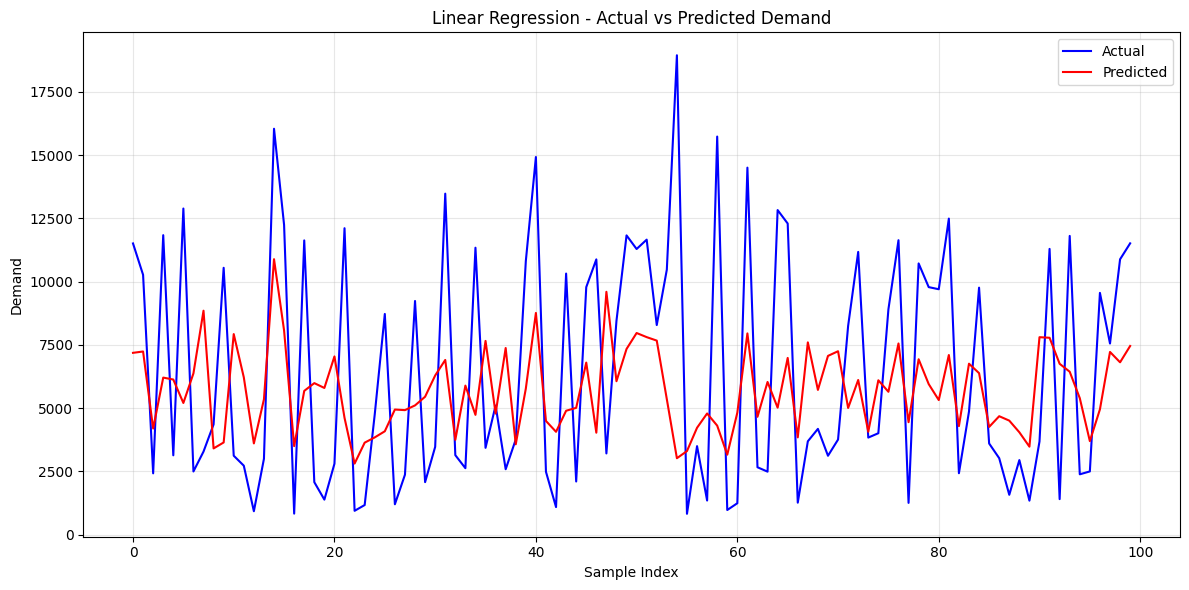

In [16]:
# Linear Regression Model
linear_model = LinearRegression()
linear_results = train_evaluate_model(
    linear_model, 'Linear Regression', 
    X_train_scaled, y_train, 
    X_test_scaled, y_test,
    baseline_metrics
)
model_results.append(linear_results)


--- Training Random Forest Model ---
Random Forest Model Performance:
MAE: 3314.78 (29.6% improvement over baseline)
RMSE: 3948.82 (34.6% improvement over baseline)
MAPE: 93.30% (33.7% improvement over baseline)
R²: 0.2208


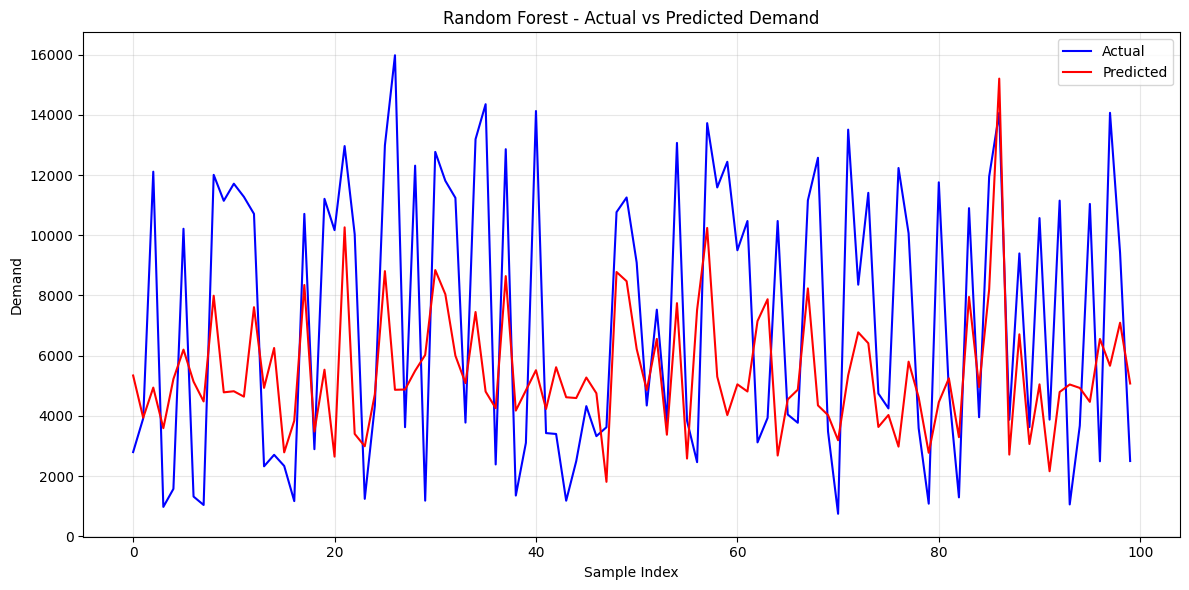

In [17]:
# Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_results = train_evaluate_model(
    rf_model, 'Random Forest', 
    X_train_scaled, y_train, 
    X_test_scaled, y_test,
    baseline_metrics
)
model_results.append(rf_results)


--- Training XGBoost Model ---
XGBoost Model Performance:
MAE: 3274.11 (30.4% improvement over baseline)
RMSE: 3853.55 (36.2% improvement over baseline)
MAPE: 93.94% (33.3% improvement over baseline)
R²: 0.2579


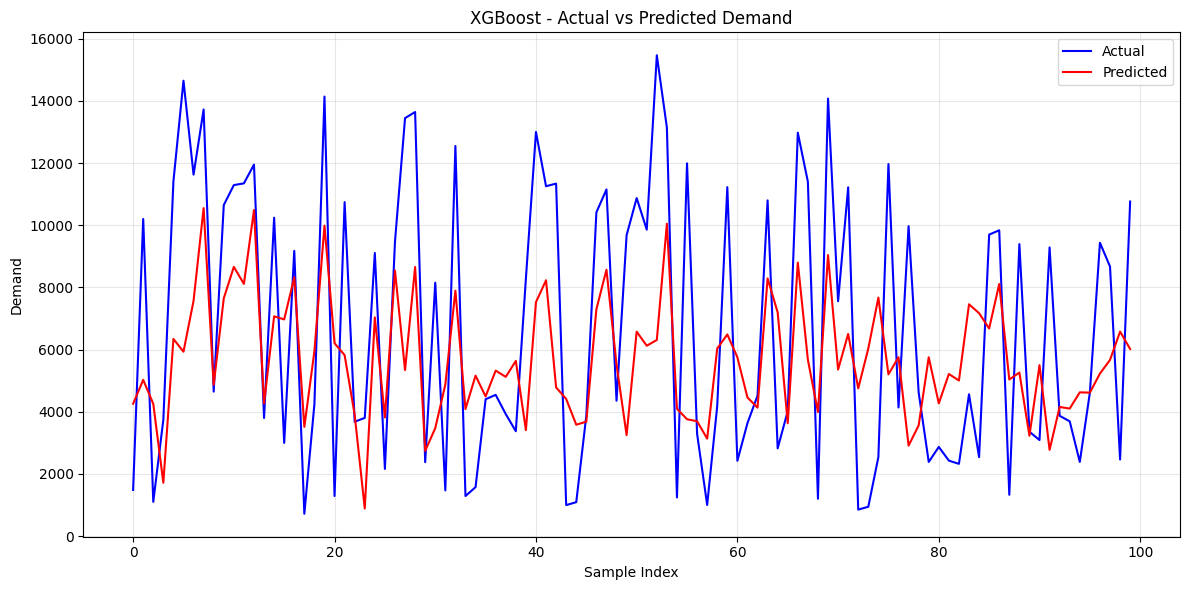

In [18]:
# XGBoost Model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
xgb_results = train_evaluate_model(
    xgb_model, 'XGBoost', 
    X_train_scaled, y_train, 
    X_test_scaled, y_test,
    baseline_metrics
)
model_results.append(xgb_results)

In [19]:
# ARIMA Model
print("\n--- Training ARIMA Model ---")
try:
    # Use a smaller subset for ARIMA to speed up execution
    train_size = min(1000, len(train_df))
    test_size = min(100, len(test_df))
    
    arima_train = train_df['demand'][-train_size:]
    arima_test = test_df['demand'][:test_size]
    
    # Train ARIMA model with order (1,1,1)
    arima_model = ARIMA(arima_train, order=(1, 1, 1))
    arima_model_fit = arima_model.fit()
    
    # Forecast
    arima_pred = arima_model_fit.forecast(steps=len(arima_test))
    
    # Calculate metrics
    arima_mae = mean_absolute_error(arima_test, arima_pred)
    arima_rmse = np.sqrt(mean_squared_error(arima_test, arima_pred))
    arima_mape = np.mean(np.abs((arima_test - arima_pred) / arima_test)) * 100
    
    # Calculate improvement
    arima_mae_improvement = ((naive_mae - arima_mae) / naive_mae) * 100
    arima_rmse_improvement = ((naive_rmse - arima_rmse) / naive_rmse) * 100
    arima_mape_improvement = ((naive_mape - arima_mape) / naive_mape) * 100
    
    print(f"ARIMA Model Performance:")
    print(f"MAE: {arima_mae:.2f} ({arima_mae_improvement:.1f}% improvement over baseline)")
    print(f"RMSE: {arima_rmse:.2f} ({arima_rmse_improvement:.1f}% improvement over baseline)")
    print(f"MAPE: {arima_mape:.2f}% ({arima_mape_improvement:.1f}% improvement over baseline)")
    
    # Visualize ARIMA predictions
    plt.figure(figsize=(12, 6))
    plt.plot(arima_test.values, 'b-', label='Actual')
    plt.plot(arima_pred, 'r-', label='ARIMA Prediction')
    plt.title('ARIMA - Actual vs Predicted Demand')
    plt.xlabel('Sample Index')
    plt.ylabel('Demand')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Store ARIMA results
    arima_results = {
        'model': 'ARIMA(1,1,1)',
        'name': 'ARIMA',
        'mae': arima_mae,
        'rmse': arima_rmse,
        'mape': arima_mape,
        'r2': None,  # R² not applicable for ARIMA
        'predictions': arima_pred
    }
    model_results.append(arima_results)
    
except Exception as e:
    print(f"Error with ARIMA modeling: {e}")
    print("Skipping ARIMA evaluation")


--- Training ARIMA Model ---
Error with ARIMA modeling: Length of values (250) does not match length of index (200)
Skipping ARIMA evaluation



--- Feature Importance Analysis ---
Feature Importance:
           Feature  Importance
       temperature    0.380299
demand_roll24_mean    0.136599
   precipIntensity    0.093923
 precipProbability    0.074127
             month    0.061350
          hour_cos    0.050573
       demand_lag1    0.048406
      demand_lag24    0.041176
     demand_lag168    0.038877
              hour    0.032950
          hour_sin    0.025041
       day_of_week    0.016678


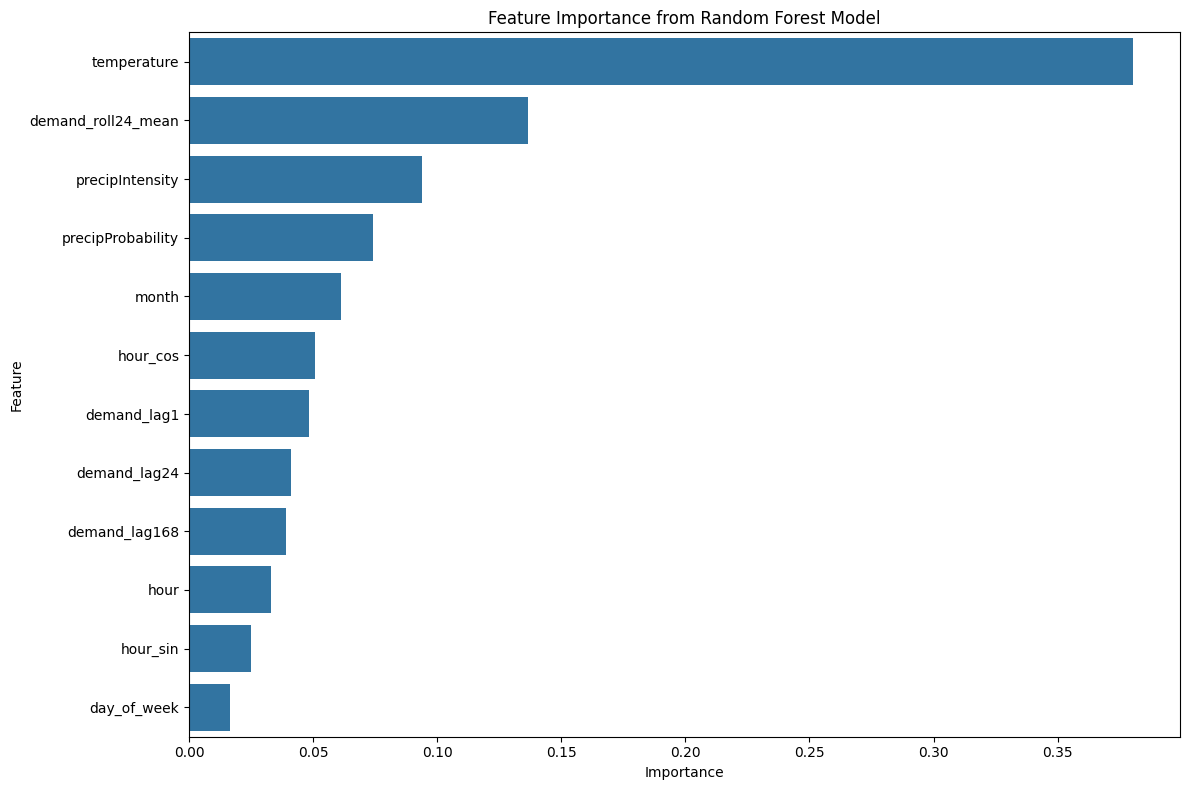

In [20]:
# Feature Importance Analysis
print("\n--- Feature Importance Analysis ---")

# Analyze feature importance from Random Forest model
if 'Random Forest' in [model['name'] for model in model_results]:
    rf_model = [model['model'] for model in model_results if model['name'] == 'Random Forest'][0]

    # Calculate feature importance
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': rf_model.feature_importances_
    })
    feature_importance.sort_values('Importance', ascending=False, inplace=True)

    print("Feature Importance:")
    print(feature_importance.to_string(index=False))

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance from Random Forest Model')
    plt.tight_layout()
    plt.show()


--- Model Comparison ---
Model Performance Comparison:
                        Model         MAE        RMSE       MAPE        R² Improvement
                      XGBoost 3274.109208 3853.548696  93.935531  0.257931       30.4%
                Random Forest 3314.775847 3948.821915  93.302391  0.220784       29.6%
            Linear Regression 3487.546843 4058.022813  96.619837  0.177091       25.9%
Naive Baseline (Previous Day) 4706.523254 6039.538588 140.750380       N/A        0.0%


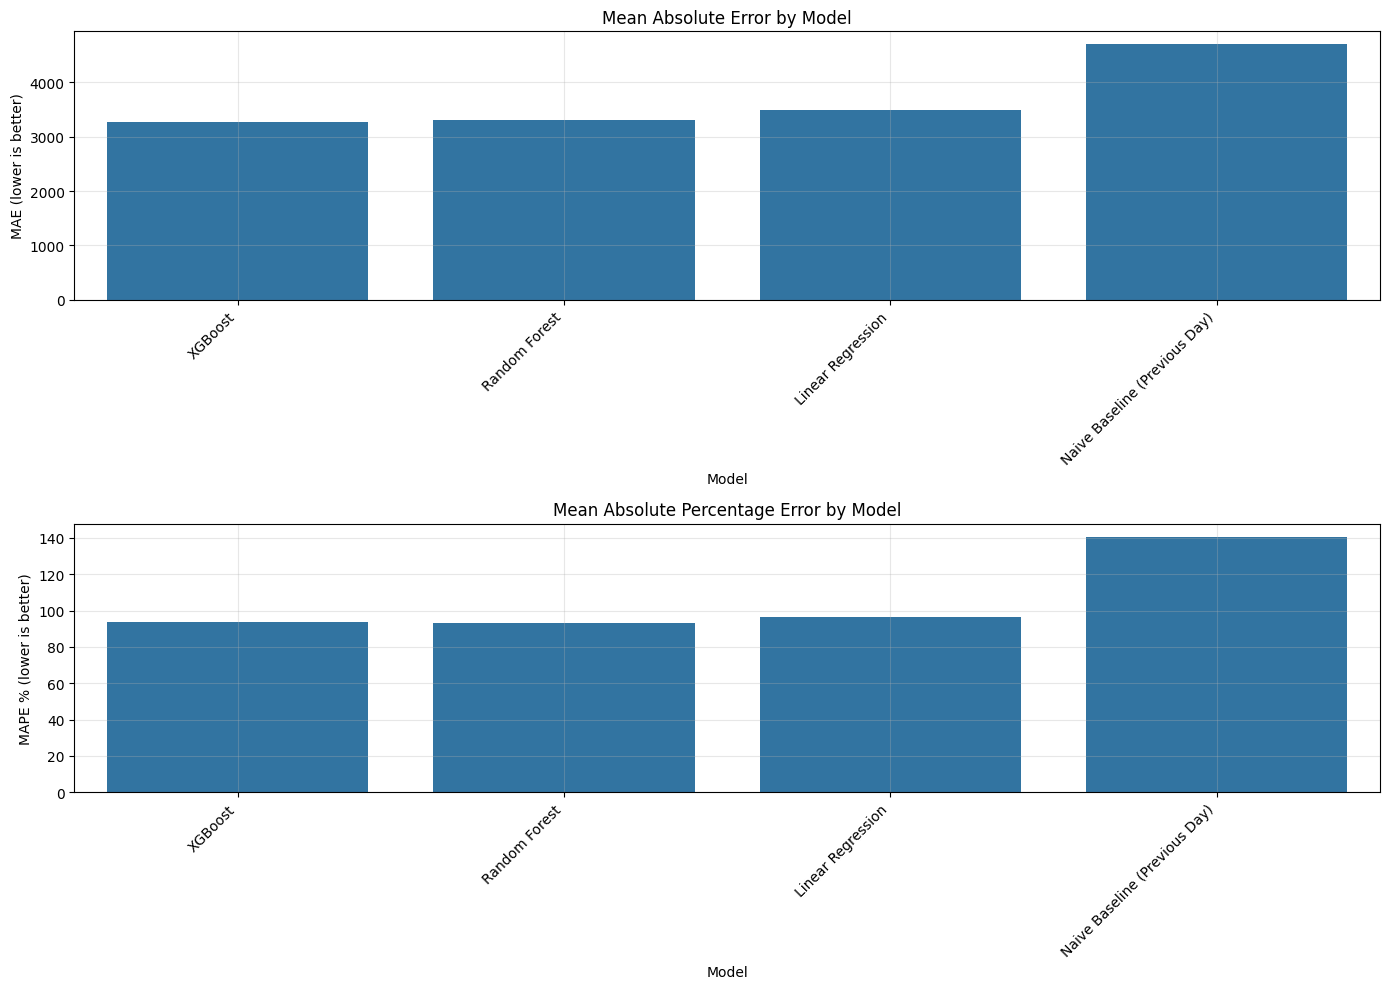

In [21]:
# Model Comparison
print("\n--- Model Comparison ---")

# Create a dataframe to compare model performance
comparison_data = [
    {
        'Model': 'Naive Baseline (Previous Day)',
        'MAE': naive_mae,
        'RMSE': naive_rmse,
        'MAPE': naive_mape,
        'R²': 'N/A',
        'Improvement': '0.0%'
    }
]

for model in model_results:
    comparison_data.append({
        'Model': model['name'],
        'MAE': model['mae'],
        'RMSE': model['rmse'],
        'MAPE': model['mape'],
        'R²': model['r2'] if model['r2'] is not None else 'N/A',
        'Improvement': f"{((naive_mae - model['mae']) / naive_mae) * 100:.1f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
# Sort by MAE (lower is better)
comparison_df.sort_values('MAE', inplace=True)

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Visualize model comparison
plt.figure(figsize=(14, 10))

# Plot MAE comparison
plt.subplot(2, 1, 1)
models = comparison_df['Model']
mae_values = comparison_df['MAE'].astype(float) if comparison_df['MAE'].dtype == object else comparison_df['MAE']
sns.barplot(x=models, y=mae_values)
plt.title('Mean Absolute Error by Model')
plt.xticks(rotation=45, ha='right')
plt.ylabel('MAE (lower is better)')
plt.grid(True, alpha=0.3)

# Plot MAPE comparison
plt.subplot(2, 1, 2)
mape_values = comparison_df['MAPE'].astype(float) if comparison_df['MAPE'].dtype == object else comparison_df['MAPE']
sns.barplot(x=models, y=mape_values)
plt.title('Mean Absolute Percentage Error by Model')
plt.xticks(rotation=45, ha='right')
plt.ylabel('MAPE % (lower is better)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Time Series Plot - Combined Models
print("\n--- Comparative Time Series Plot ---")

# Select a portion of test data for clearer visualization
vis_period = min(100, len(test_df))
vis_test = test_df.iloc[:vis_period]
vis_y_test = y_test.